<a href="https://colab.research.google.com/github/AhlemAmmar/AI-Powered-FAQ-Bot-RAG-based-/blob/main/AI_Powered_blog_Bot_(RAG_based).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph

###




### Setup

In [21]:
from google.colab import userdata
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"]=userdata.get('LANGSMITH_API_KEY')



1. ***chat model: Google Gemini***



In [22]:
%pip install -qU "langchain[google-genai]"

In [23]:

if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')


In [24]:
from langchain.chat_models import init_chat_model
# chat model
llm = init_chat_model("gemini-2.5-flash", model_provider="google_genai")

2. ***embeddings model: OpenAI***

In [25]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
#embeddings model:
embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")

3. ***vector store: In-memory***

In [26]:
%pip install -qU langchain-core

In [27]:
from langchain_core.vectorstores import InMemoryVectorStore
#vector store
vector_store = InMemoryVectorStore(embeddings)

### RAG chain

In [28]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

In [29]:


# Load and chunk contents of the blog
"""WebBaseLoader:
uses urllib to load HTML from web URLs and BeautifulSoup to parse it to text.
"""
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            # Only keep post title, headers, and content from the full HTML.
            class_=("post-content", "post-title", "post-header")
        )
    ),
)

"""
DocumentLoader: Object that loads data from a source as list of Documents.
"""
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 43047


In [30]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


In [31]:
# Splitting documents
"""
TextSplitter: Object that splits a list of Documents into smaller chunks. Subclass of DocumentTransformer
"""
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,# chunk size (characters)
    chunk_overlap=200 # chunk overlap (characters)
    )
# recursively split the document using common separators like new lines until each chunk is the appropriate size.
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 63 sub-documents.


In [32]:
# Storing documents

"""
 embed the contents of each document split and insert these embeddings into a vector store
 """
_ = vector_store.add_documents(documents=all_splits)

In [33]:
# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")

In [34]:
example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [35]:
"""
To use LangGraph, we need to define three things:

The state of our application;
The nodes of our application (i.e., application steps);
The "control flow" of our application (e.g., the ordering of the steps).
"""



# Define state for application
# The state of our application controls what data is input to the application, transferred between steps, and output by the application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps : NODES

def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}



In [36]:
# Control flow
## Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [37]:
response = graph.invoke({"question": "give me a summary "})
print(response["answer"])

Human memory is categorized into Short-Term Memory (STM) and Long-Term Memory (LTM). STM, also known as working memory, holds about 7 items for 20-30 seconds, used for current cognitive tasks. LTM has an unlimited capacity and duration, encompassing explicit memory (facts and events like episodic and semantic) and implicit memory (unconscious skills and routines).


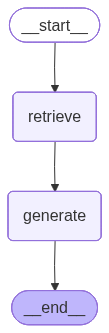

In [38]:
from IPython.display import Image, display
# Due to heavy traffic, https://mermaid.ink/ is struggle to operate normally.
display(Image(graph.get_graph().draw_mermaid_png()))